In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Loaded original grayscale image
img_path = "lena512.bmp" 
original_img = Image.open(img_path).convert("L")
original_array = np.array(original_img)


## Step 1: Preprocessing
L loedad the 512×512 grayscale Lena image. Since the dimensions are already divisible by 8, no cropping or resizing is needed.

In [21]:
def compress_block(block, k):
    U, S, VT = np.linalg.svd(block, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    VT_k = VT[:k, :]
    return np.dot(U_k, np.dot(S_k, VT_k))

def compress_image(img_array, k):
    h, w = img_array.shape
    compressed_img = np.zeros_like(img_array, dtype=np.float32)
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img_array[i:i+8, j:j+8]
            compressed_img[i:i+8, j:j+8] = compress_block(block, k)
    return np.clip(compressed_img, 0, 255).astype(np.uint8)

def compute_compression_ratio(k):
    return 64 / (k * (8 + 8 + 1))  # 64 / (17k)

def compute_frobenius_error(orig, comp):
    return np.linalg.norm(orig.astype(np.float32) - comp.astype(np.float32))

def compute_psnr(orig, comp):
    mse = np.mean((orig - comp) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))


## Step 2: Block-wise SVD Compression
define helper functions for:
- `compress_block`: applies SVD to each 8×8 block and reconstructs with top-k singular values.
- `compress_image`: applies compression across all blocks.

In [23]:
# Initializing lists
reconstructed_images = [original_array]
compression_ratios = []
errors = []
psnrs = []

# Compressing image with k=1 to 8 and storing results
for k in range(1, 9):
    comp_img = compress_image(original_array, k)
    reconstructed_images.append(comp_img)
    compression_ratios.append(compute_compression_ratio(k))
    errors.append(compute_frobenius_error(original_array, comp_img))
    psnrs.append(compute_psnr(original_array, comp_img))


## Step 3: Compression Analysis

For each k from 1 to 8,applied block-wise compression and calculated:
- Compression Ratio
- Reconstruction Error (Frobenius Norm)
- PSNR

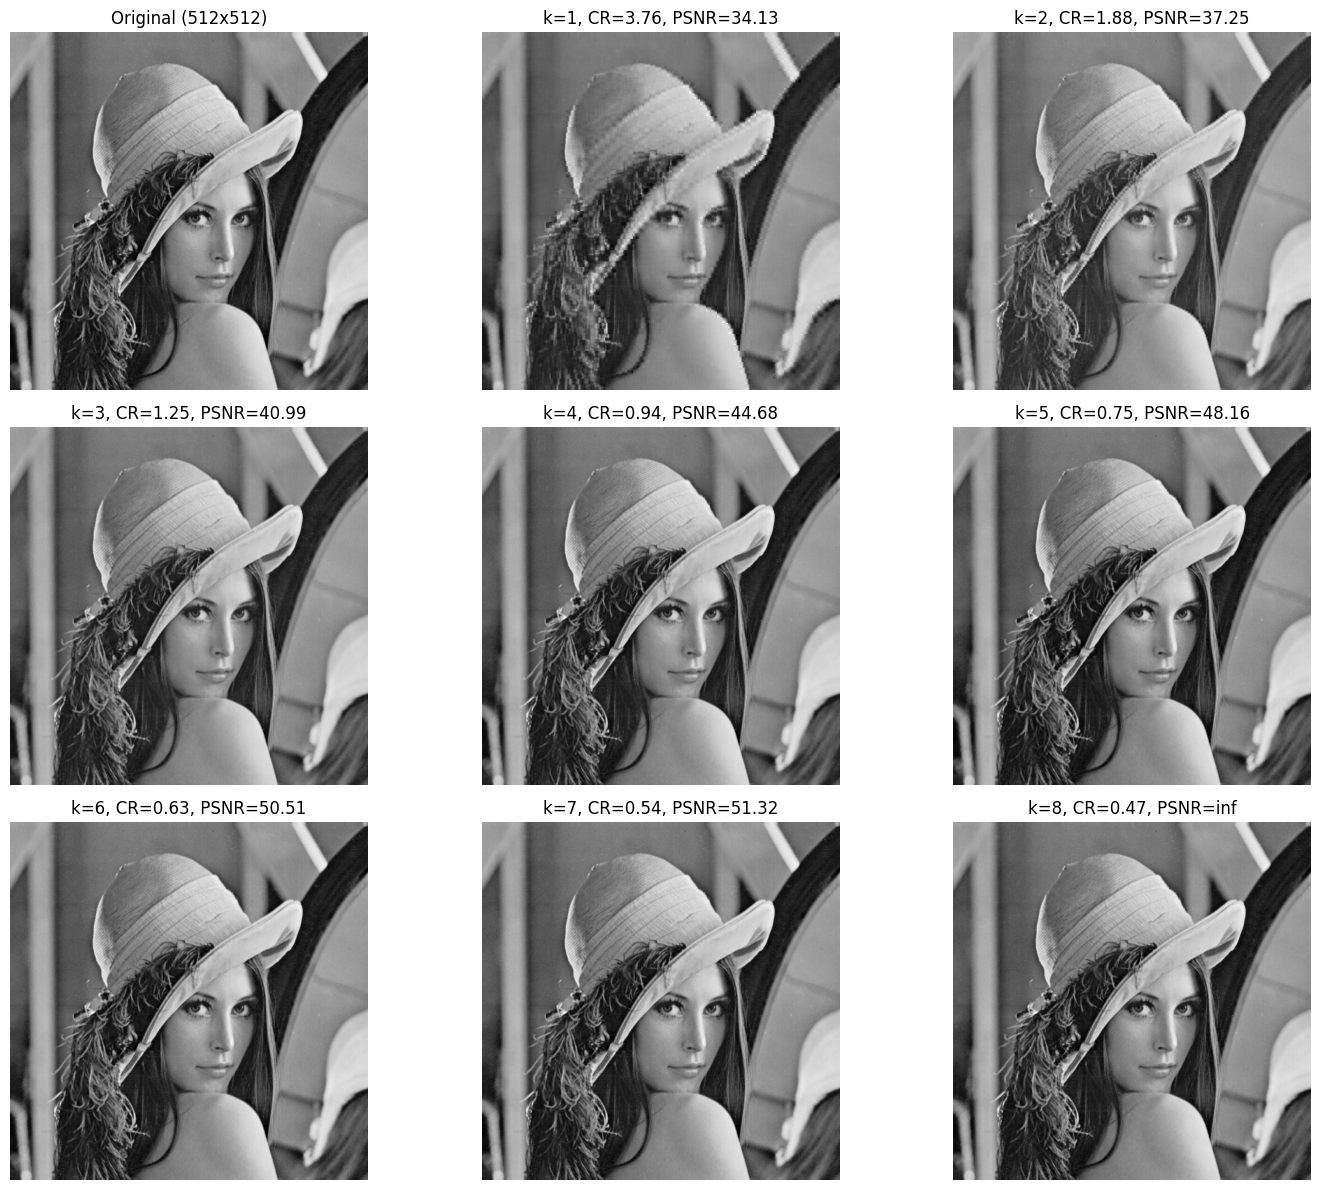

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx, ax in enumerate(axes.flat):
    img = reconstructed_images[idx]
    ax.imshow(img, cmap='gray')
    
    if idx == 0:
        ax.set_title("Original (512x512)")
    else:
        cr = compression_ratios[idx - 1]
        psnr_val = psnrs[idx - 1]
        ax.set_title(f"k={idx}, CR={cr:.2f}, PSNR={psnr_val:.2f}")
    
    ax.axis("off")

plt.tight_layout()
plt.show()


## Step 4: Compressed Images Grid

Visualized the original and compressed images in a 3×3 layout with CR and PSNR annotations.

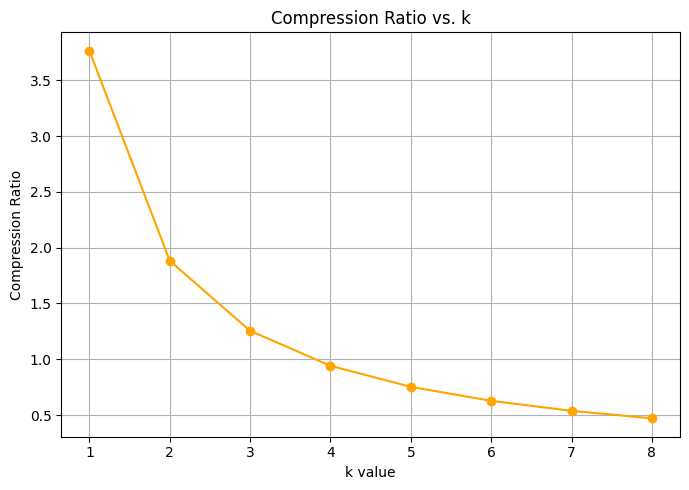

In [24]:
#Compression Ratio vs. k
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(range(1, 9), compression_ratios, marker='o', color='orange')
plt.title("Compression Ratio vs. k")
plt.xlabel("k value")
plt.ylabel("Compression Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


This plot shows how the compression ratio changes as the number of singular values (k) increases.

- As k increases, more data is retained, so the compression ratio decreases.
- At low values of k (e.g., 1–3), the compression ratio is high, but image quality is low.
- This plot highlights the inverse relationship between compression and information retention.

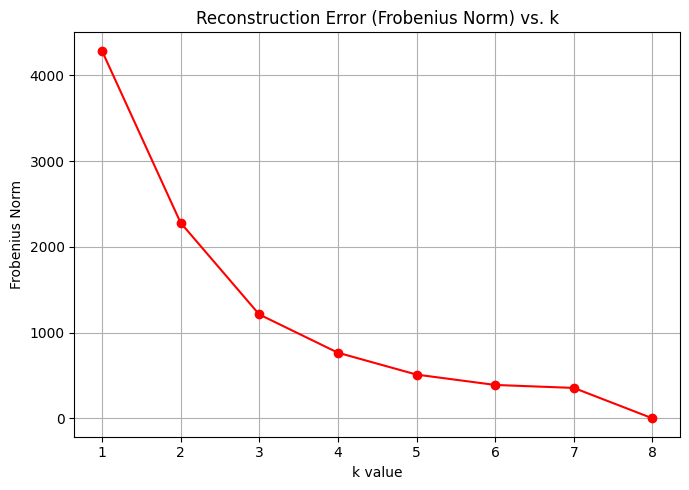

In [27]:
#Reconstruction Error (Frobenius norm) vs. k
plt.figure(figsize=(7, 5))
plt.plot(range(1, 9), errors, marker='o', color='red')
plt.title("Reconstruction Error (Frobenius Norm) vs. k")
plt.xlabel("k value")
plt.ylabel("Frobenius Norm")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows the reconstruction error (Frobenius norm) for each value of k.

- The Frobenius norm measures how different the compressed image is from the original.
- As k increases, the error decreases rapidly, especially in the range of k = 1 to 5.
- At k = 8, the error becomes 0, indicating perfect reconstruction.


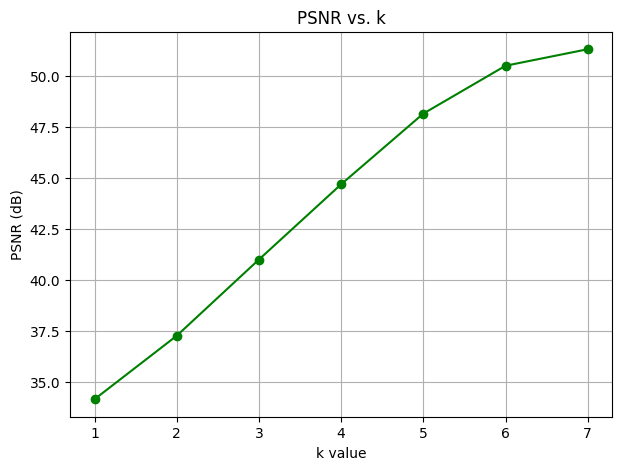

In [45]:
# PSNR vs. k
plt.figure(figsize=(7, 5))
plt.plot(range(1, 9), psnrs, marker='o', color='green')
plt.title("PSNR vs. k")
plt.xlabel("k value")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.show()


This plot shows the Peak Signal-to-Noise Ratio (PSNR) for each compressed image.

- Higher PSNR values indicate better image quality.
- As expected, PSNR increases with k, reflecting improved visual fidelity.
- At k = 8, the PSNR is infinite because the reconstruction is exact and error-free.


In [33]:
import pandas as pd

results_df = pd.DataFrame({
    "k": list(range(1, 9)),
    "Compression Ratio": compression_ratios,
    "Frobenius Error": errors,
    "PSNR (dB)": psnrs
})

results_df


,k,Compression Ratio,Frobenius Error,PSNR (dB)
0,1,3.764706,4288.712402,34.132130
1,2,1.882353,2282.395508,37.249117
2,3,1.254902,1212.077148,40.991214
3,4,0.941176,765.692505,44.684702
4,5,0.752941,510.550690,48.155426
5,6,0.627451,389.545898,50.505030
6,7,0.537815,354.825317,51.315911
7,8,0.470588,0.000000,inf


### Step 6: Summary Table of Compression Results

DataFrame summarizing the key metrics for each value of k (the number of singular values retained during SVD compression). Specifically, it includes:

- **Compression Ratio**: The ratio of original data size to the retained data size using the formula `64 / (17k)`.
- **Frobenius Error**: The reconstruction error calculated using the Frobenius norm between the original and compressed image.
- **PSNR (dB)**: Peak Signal-to-Noise Ratio, a standard measure of image quality — higher values indicate better visual fidelity.

This table helps compare how image quality and compression performance vary with different levels of approximation (k).
